In [2]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [20]:
# Function to convert color image to grayscale
def rgb_to_gray(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

# Path to the directory containing color images
color_image_path='../color'

# Path to the directory where grayscale images will be saved
grayscale_image_path='../gray'

# Create the grayscale image directory if it doesn't exist
os.makedirs(grayscale_image_path, exist_ok=True)

# Iterate over each color image in the directory
for filename in tqdm(os.listdir(color_image_path)):
    try:
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
            # Read the color image
            color_image = cv2.imread(os.path.join(color_image_path, filename))
            if color_image is None:
                print(f"Failed to read image: {filename}")
                continue
            
            # Convert color image to grayscale
            grayscale_image = rgb_to_gray(color_image)
            
            # Save the grayscale image to the grayscale image directory with correct color mode
            cv2.imwrite(os.path.join(grayscale_image_path, filename), grayscale_image, [cv2.IMWRITE_JPEG_QUALITY, 100])
    except Exception as e:
        print(f"Error processing image: {filename}. Error: {e}")

print("Grayscale images have been saved to:", grayscale_image_path)


100%|██████████████████████████████████████| 5501/5501 [00:14<00:00, 378.99it/s]

Grayscale images have been saved to: /Users/jacopo/Library/CloudStorage/GoogleDrive-jacopo.raffaelli.00@gmail.com/My Drive/Università/TUWien/Year 1/Semester 1/Machine Learning/Assignment 3/code/gray


In [21]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 160
color_img = []
path='../color'
files = os.listdir(path)
files = sorted_alphanumeric(files)

for i in tqdm(files):    
    try:
        if i.endswith('.jpg'):
            img = cv2.imread(os.path.join(path, i), 1)
            if img is None:
                print(f"Failed to read image: {i}")
                continue
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (SIZE, SIZE))
            img = img.astype('float32') / 255.0
            color_img.append(img)
    except Exception as e:
        print(f"Error processing image: {i}. Error: {e}")

print("Number of images processed:", len(color_img))


gray_img = []
path = '../gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)

for i in tqdm(files):
    try:
        if i.endswith('.jpg'):
            img = cv2.imread(os.path.join(path, i), 0)  # Read image in grayscale mode (0)
            if img is None:
                print(f"Failed to read image: {i}")
                continue

            img = cv2.resize(img, (SIZE, SIZE))
            img = img.astype('float32') / 255.0
            gray_img.append(img_to_array(img))
            
    except Exception as e:
        print(f"Error processing image: {i}. Error: {e}")

print("Number of grayscale images processed:", len(gray_img))
         

100%|██████████████████████████████████████| 5501/5501 [00:10<00:00, 541.49it/s]


Number of images processed: 5500


100%|██████████████████████████████████████| 5500/5500 [00:09<00:00, 580.81it/s]

Number of grayscale images processed: 5500


In [24]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale, cmap="gray")
   
    plt.show()

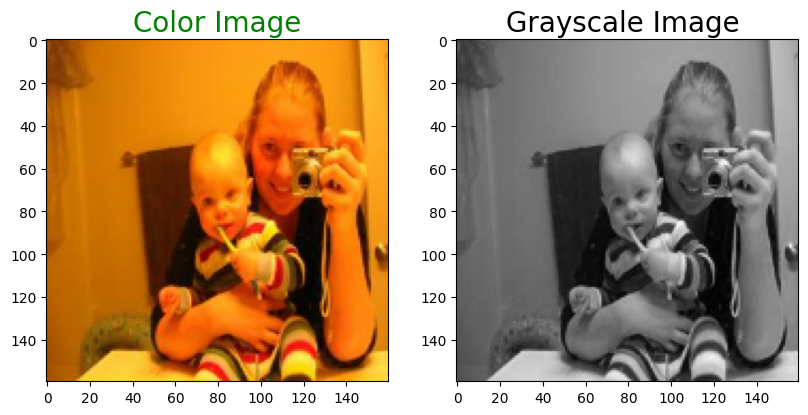

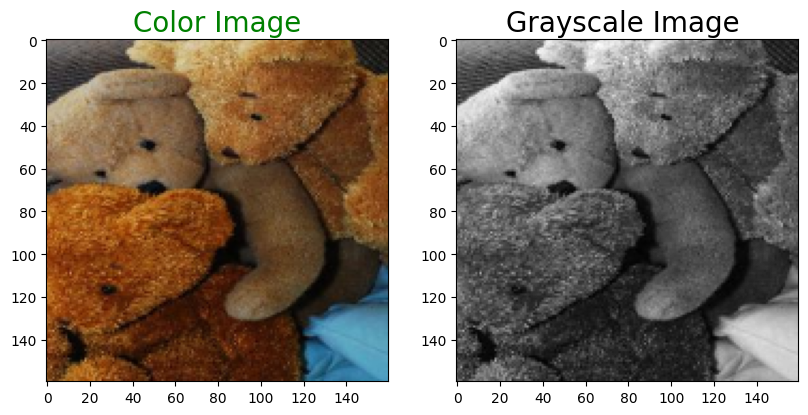

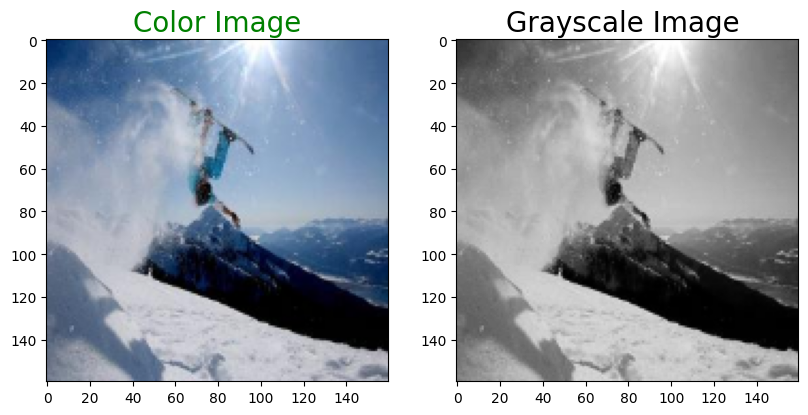

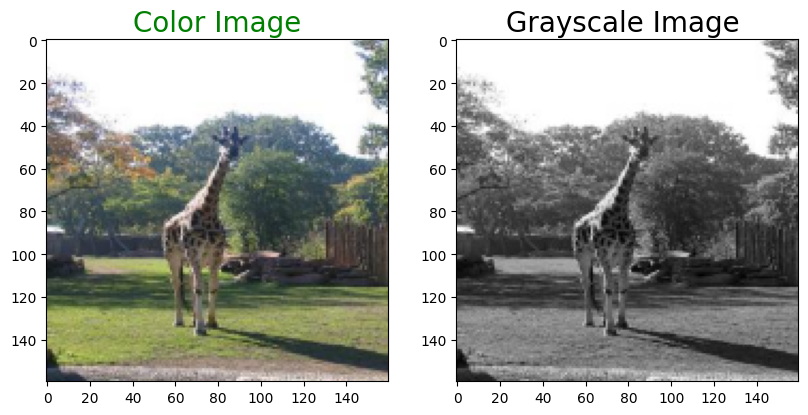

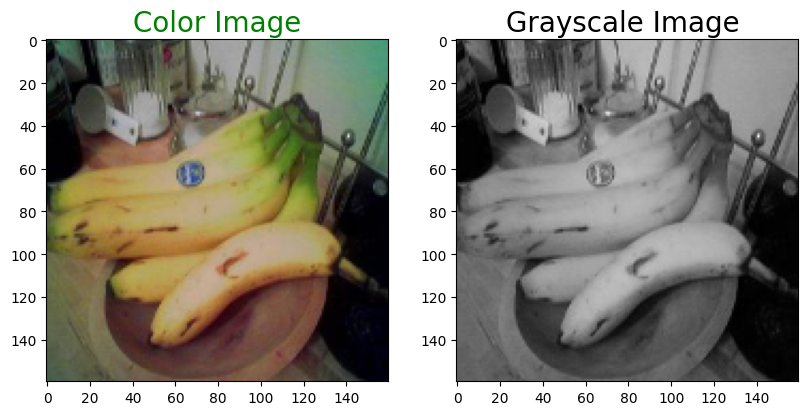

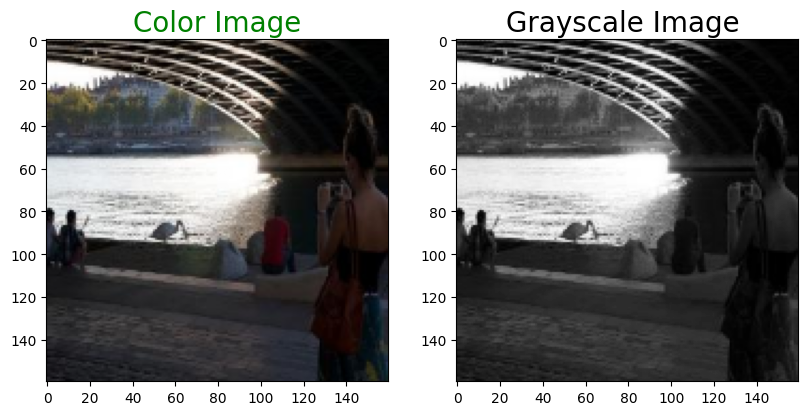

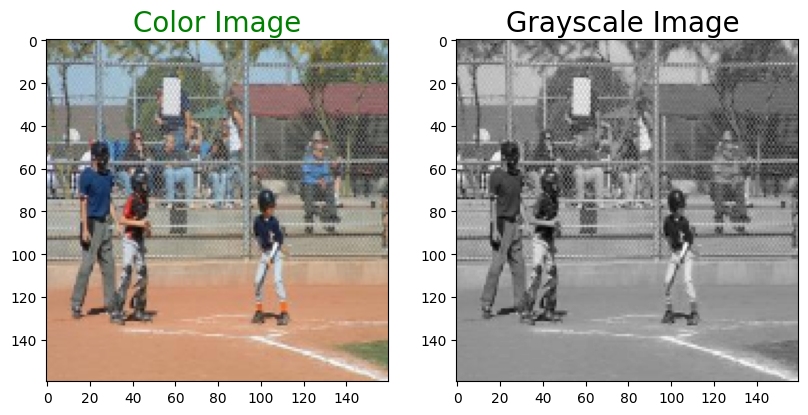

In [25]:
for i in range(3,10):
     plot_images(color_img[i],gray_img[i])

In [44]:
train_gray_image = np.array(gray_img[:4000])
train_color_image = np.array(color_img[:4000])

test_gray_image = np.array(gray_img[4000:])
test_color_image = np.array(color_img[4000:])
# reshaping
train_gray_image = np.repeat(train_gray_image, 3, axis=-1)
test_gray_image = np.repeat(test_gray_image, 3, axis=-1)

#train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
#train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_color_image.shape)


#test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
#test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (4000, 160, 160, 3)
Test color image shape (1500, 160, 160, 3)


In [39]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample


In [40]:
def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [41]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 80, 80, 128)          3584      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 40, 40, 128)          147584    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 20, 20, 256)          296192    ['sequential_1[0][0]']        
                                                                                              

In [42]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_g, train_c, epochs = 50,batch_size = 50,verbose = 0)

In [45]:
model.evaluate(test_gray_image,test_color_image)

47/47 [==============================] - 38s 778ms/step - loss: 0.0519 - acc: 0.5039


[0.05188947543501854, 0.5038768649101257]

1/1 [==============================] - 0s 120ms/step


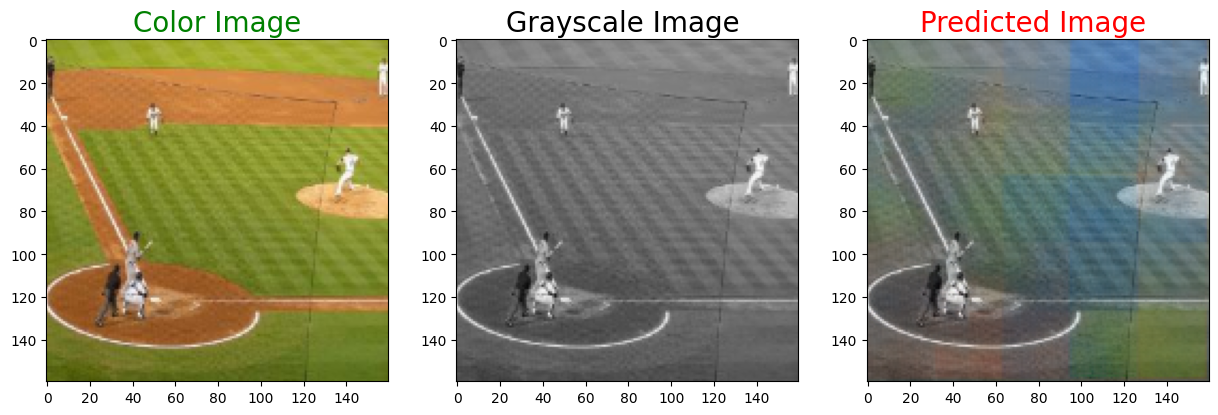

1/1 [==============================] - 0s 76ms/step


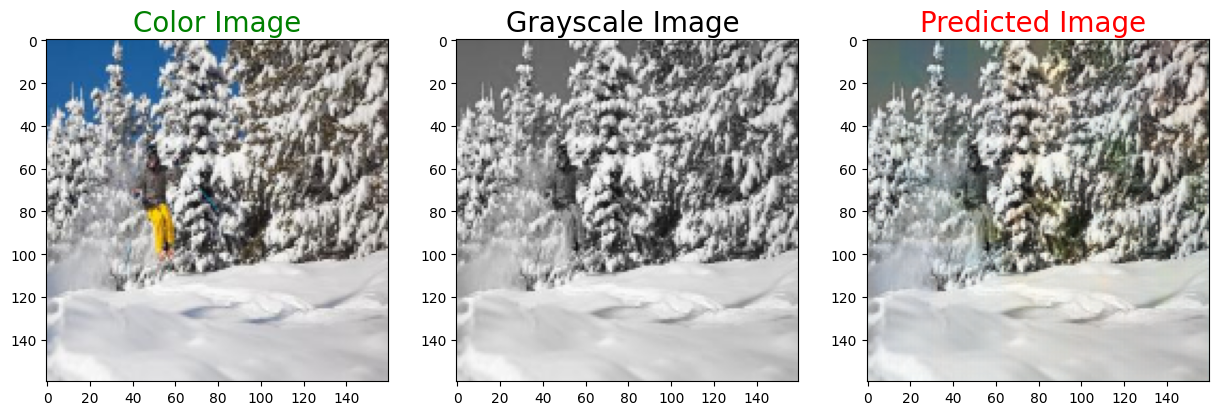

1/1 [==============================] - 0s 93ms/step


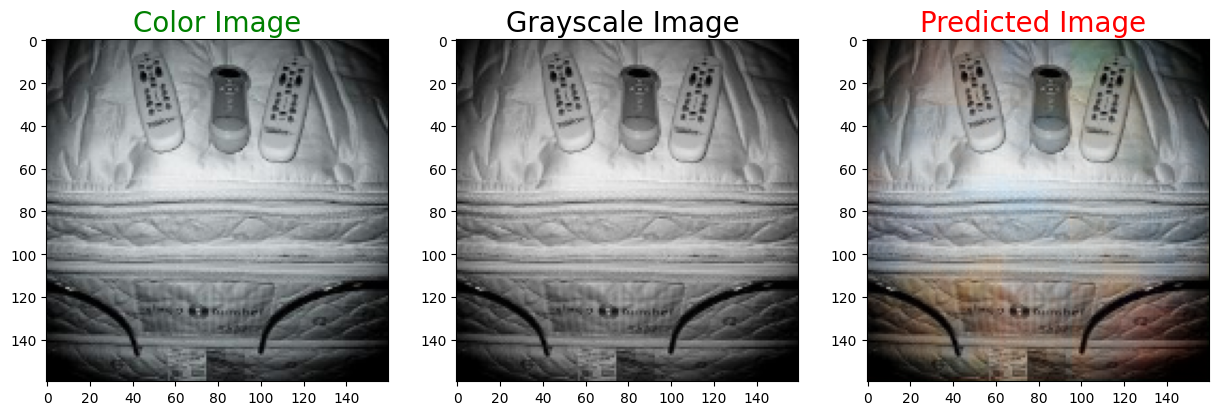

1/1 [==============================] - 0s 72ms/step


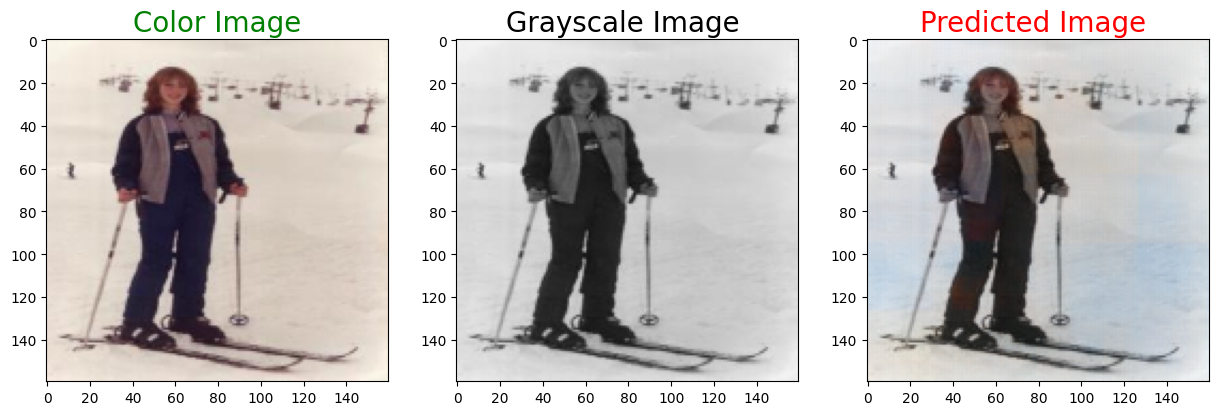

1/1 [==============================] - 0s 71ms/step


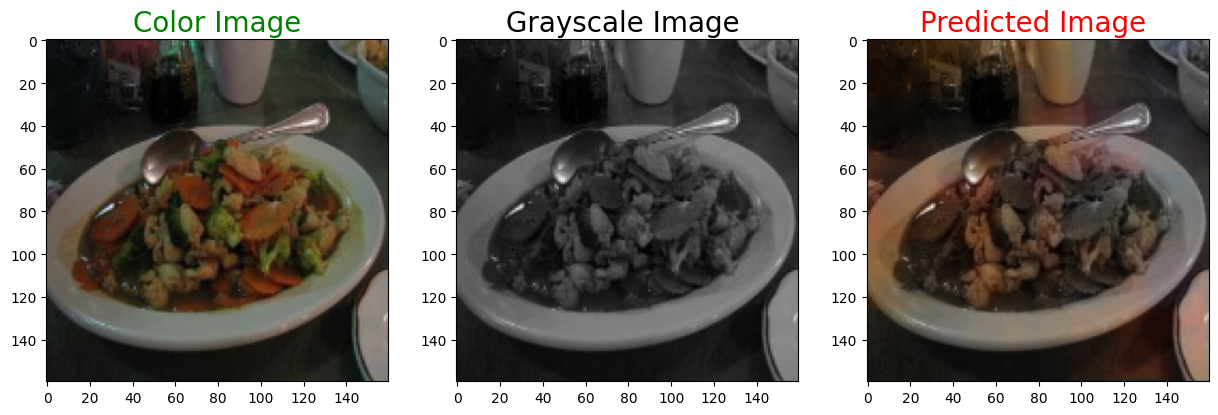

1/1 [==============================] - 0s 70ms/step


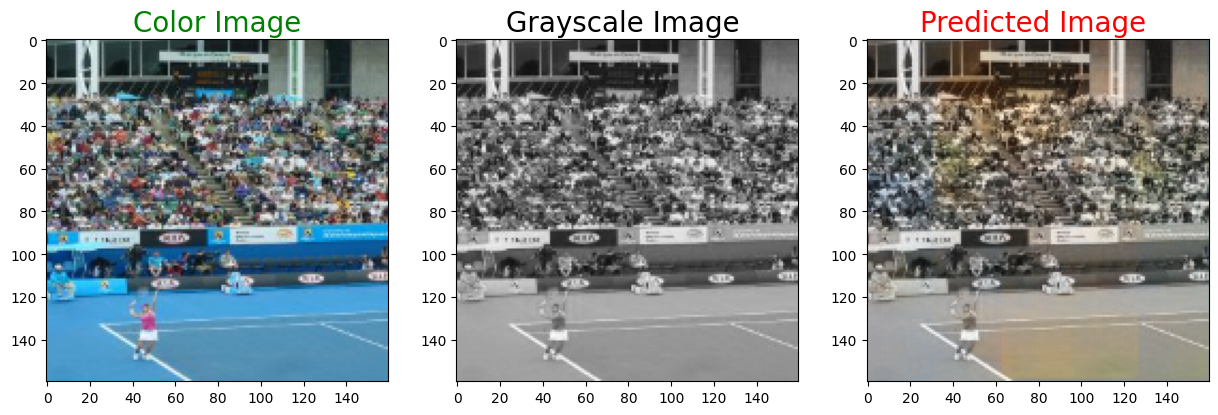

1/1 [==============================] - 0s 74ms/step


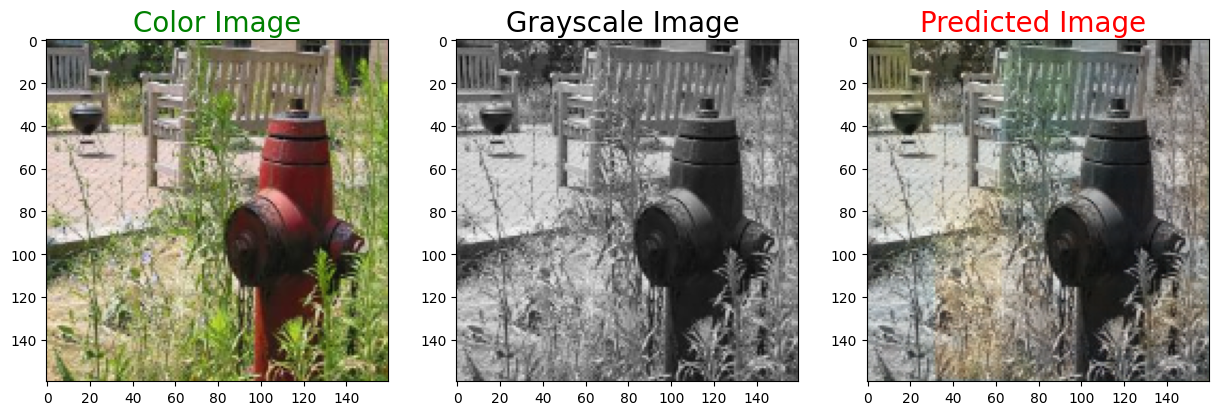

In [47]:
# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(58,65):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i],test_gray_image[i],predicted)

 

In [49]:
model_file_path = '../model'

model.save(model_file_path)


INFO:tensorflow:Assets written to: /Users/jacopo/Library/CloudStorage/GoogleDrive-jacopo.raffaelli.00@gmail.com/My Drive/Università/TUWien/Year 1/Semester 1/Machine Learning/Assignment 3/code/model/assets


INFO:tensorflow:Assets written to: /Users/jacopo/Library/CloudStorage/GoogleDrive-jacopo.raffaelli.00@gmail.com/My Drive/Università/TUWien/Year 1/Semester 1/Machine Learning/Assignment 3/code/model/assets
